In [1]:
import os

import pandas as pd
from sqlalchemy import create_engine
from dotenv import load_dotenv

load_dotenv()


def batch_load_sql(query: str) -> pd.DataFrame:
    CHUNKSIZE = 200000
    engine = create_engine(os.getenv('DATABASE'))
    conn = engine.connect().execution_options(stream_results=True)
    chunks = []
    for chunk_dataframe in pd.read_sql(query, conn, chunksize=CHUNKSIZE):
        chunks.append(chunk_dataframe)
    conn.close()
    return pd.concat(chunks, ignore_index=True)

def load_features(select) -> pd.DataFrame:
    return batch_load_sql(select)


In [2]:
query = """
SELECT *
FROM post_text_df
"""
posts_df = load_features(query)

posts_df.head()

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,3,Asian quake hits European shares\n\nShares in ...,business
3,4,India power shares jump on debut\n\nShares in ...,business
4,5,Lacroix label bought by US firm\n\nLuxury good...,business


In [3]:
# Find total likes, likes rate for every post

In [4]:
query = """
SELECT COUNT(*), post_id
FROM feed_data
WHERE action = 'like'
GROUP BY post_id;
"""
posts_likes = load_features(query)
posts_likes = posts_likes.set_index('post_id')

In [5]:
posts_df['total_likes'] = posts_df['post_id'].map(posts_likes['count'])

In [6]:
query = """
SELECT COUNT(*), post_id
FROM feed_data
GROUP BY post_id;
"""
posts_actions = load_features(query)
posts_actions = posts_actions.set_index('post_id')

In [7]:
posts_df['like_rate'] = posts_df['post_id'].map(posts_likes['count']/posts_actions['count'])

In [8]:
posts_df.isnull().sum()

post_id          0
text             0
topic            0
total_likes    192
like_rate      192
dtype: int64

In [9]:
posts_df['like_rate'] = posts_df['like_rate'].fillna(posts_df['like_rate'].mean())
posts_df['total_likes'] = posts_df['total_likes'].fillna(posts_df['total_likes'].mean())

In [10]:
# Add feature - average age for each post

In [11]:
query = """
SELECT AVG(u.age), p.post_id
FROM feed_data as f
JOIN user_data as u
ON f.user_id = u.user_id
JOIN post_text_df as p
ON f.post_id = p.post_id
WHERE action = 'like'
GROUP BY p.post_id
"""
posts_age_likes = load_features(query)
posts_age_likes = posts_age_likes.set_index('post_id')

In [12]:
posts_df['avg_age_likes'] = posts_df['post_id'].map(posts_age_likes['avg'])

In [13]:
posts_df.isnull().sum()

post_id            0
text               0
topic              0
total_likes        0
like_rate          0
avg_age_likes    192
dtype: int64

In [14]:
posts_df['avg_age_likes'] = posts_df['avg_age_likes'].fillna(posts_df['avg_age_likes'].mean())

In [15]:
# Add feature - total length for each post (symbols)

In [16]:
query = """
SELECT post_id, LENGTH(text) AS post_len
FROM post_text_df;
"""
posts_len = load_features(query)
posts_len = posts_len.set_index('post_id')

In [17]:
posts_df['post_len'] = posts_df['post_id'].map(posts_len['post_len'])

In [18]:
posts_df

,post_id,text,topic,total_likes,like_rate,avg_age_likes,post_len
0,1,UK economy facing major risks\n\nThe UK manufa...,business,1067.0,0.111436,29.099344,1967
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,637.0,0.078333,31.910518,2701
2,3,Asian quake hits European shares\n\nShares in ...,business,1122.0,0.117684,29.262923,3408
3,4,India power shares jump on debut\n\nShares in ...,business,1171.0,0.125523,29.084543,1026
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,1153.0,0.118426,29.479618,889
...,...,...,...,...,...,...,...
7018,7315,"OK, I would not normally watch a Farrelly brot...",movie,2619.0,0.133903,22.554792,803
7019,7316,I give this movie 2 stars purely because of it...,movie,677.0,0.093392,31.441654,800
7020,7317,I cant believe this film was allowed to be mad...,movie,731.0,0.097027,31.885089,636
7021,7318,The version I saw of this film was the Blockbu...,movie,680.0,0.091092,32.423529,728


In [19]:
# Add feature - average sentence length (len text in words / sentences count)

In [20]:
query_word = """
SELECT 
    post_id,
    text,
    array_length(
        regexp_split_to_array(
            trim(regexp_replace(text, '[\s\-\.,;:!?\(\)]+', ' ', 'g')), 
            ' '
        ),
        1
    ) AS word_count
FROM post_text_df;
"""

In [21]:
query_sent = """
SELECT
    post_id,
    text,
    length(
        regexp_replace(text, '[^.!?]+', '', 'g')
    )
    + CASE
        WHEN regexp_replace(trim(text), '.*[.!?]\s*$', '') <> ''
        THEN 1 ELSE 0 END
    AS sentence_count
FROM post_text_df;    
"""

In [22]:
posts_word = load_features(query_word)
posts_word = posts_word.set_index('post_id')
posts_sent = load_features(query_sent)
posts_sent = posts_sent.set_index('post_id')

In [23]:
posts_word

,text,word_count
post_id,,
1,UK economy facing major risks\n\nThe UK manufa...,327
2,Aids and climate top Davos agenda\n\nClimate c...,449
3,Asian quake hits European shares\n\nShares in ...,571
4,India power shares jump on debut\n\nShares in ...,178
5,Lacroix label bought by US firm\n\nLuxury good...,156
...,...,...
7315,"OK, I would not normally watch a Farrelly brot...",158
7316,I give this movie 2 stars purely because of it...,154
7317,I cant believe this film was allowed to be mad...,113


In [24]:
posts_sent

,text,sentence_count
post_id,,
1,UK economy facing major risks\n\nThe UK manufa...,17
2,Aids and climate top Davos agenda\n\nClimate c...,19
3,Asian quake hits European shares\n\nShares in ...,52
4,India power shares jump on debut\n\nShares in ...,11
5,Lacroix label bought by US firm\n\nLuxury good...,7
...,...,...
7315,"OK, I would not normally watch a Farrelly brot...",12
7316,I give this movie 2 stars purely because of it...,14
7317,I cant believe this film was allowed to be mad...,19


In [25]:
posts_avg_len = posts_word.join(posts_sent, lsuffix='_word', rsuffix='_sent')
posts_avg_len['avg_sent_len'] = posts_avg_len['word_count']/posts_avg_len['sentence_count']
posts_avg_len = posts_avg_len[['text_word', 'avg_sent_len']].rename(columns={'text_word': 'text'})
posts_avg_len.reset_index()

,post_id,text,avg_sent_len
0,1,UK economy facing major risks\n\nThe UK manufa...,19.235294
1,2,Aids and climate top Davos agenda\n\nClimate c...,23.631579
2,3,Asian quake hits European shares\n\nShares in ...,10.980769
3,4,India power shares jump on debut\n\nShares in ...,16.181818
4,5,Lacroix label bought by US firm\n\nLuxury good...,22.285714
...,...,...,...
7018,7315,"OK, I would not normally watch a Farrelly brot...",13.166667
7019,7316,I give this movie 2 stars purely because of it...,11.000000
7020,7317,I cant believe this film was allowed to be mad...,5.947368
7021,7318,The version I saw of this film was the Blockbu...,13.000000


In [26]:
posts_avg_len

,text,avg_sent_len
post_id,,
1,UK economy facing major risks\n\nThe UK manufa...,19.235294
2,Aids and climate top Davos agenda\n\nClimate c...,23.631579
3,Asian quake hits European shares\n\nShares in ...,10.980769
4,India power shares jump on debut\n\nShares in ...,16.181818
5,Lacroix label bought by US firm\n\nLuxury good...,22.285714
...,...,...
7315,"OK, I would not normally watch a Farrelly brot...",13.166667
7316,I give this movie 2 stars purely because of it...,11.000000
7317,I cant believe this film was allowed to be mad...,5.947368


In [27]:
posts_df['avg_sent_len'] = posts_df['post_id'].map(posts_avg_len['avg_sent_len'])

In [28]:
posts_df

,post_id,text,topic,total_likes,like_rate,avg_age_likes,post_len,avg_sent_len
0,1,UK economy facing major risks\n\nThe UK manufa...,business,1067.0,0.111436,29.099344,1967,19.235294
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,637.0,0.078333,31.910518,2701,23.631579
2,3,Asian quake hits European shares\n\nShares in ...,business,1122.0,0.117684,29.262923,3408,10.980769
3,4,India power shares jump on debut\n\nShares in ...,business,1171.0,0.125523,29.084543,1026,16.181818
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,1153.0,0.118426,29.479618,889,22.285714
...,...,...,...,...,...,...,...,...
7018,7315,"OK, I would not normally watch a Farrelly brot...",movie,2619.0,0.133903,22.554792,803,13.166667
7019,7316,I give this movie 2 stars purely because of it...,movie,677.0,0.093392,31.441654,800,11.000000
7020,7317,I cant believe this film was allowed to be mad...,movie,731.0,0.097027,31.885089,636,5.947368
7021,7318,The version I saw of this film was the Blockbu...,movie,680.0,0.091092,32.423529,728,13.000000


In [29]:
posts_df.isnull().sum()

post_id          0
text             0
topic            0
total_likes      0
like_rate        0
avg_age_likes    0
post_len         0
avg_sent_len     0
dtype: int64

In [30]:
# Add tsne features

In [57]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler


X = posts_df[['total_likes', 'like_rate', 'avg_age_likes', 'post_len', 'avg_sent_len']]

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

tsne = TSNE(n_components=2, random_state=42, perplexity=10, max_iter=1000)

X_tsne = tsne.fit_transform(X_scaled)

In [58]:
X_tsne

array([[-52.966164 ,  10.966164 ],
       [ 44.157722 ,  67.41605  ],
       [-45.25845  ,  29.406063 ],
       ...,
       [ -1.4842124, -22.95448  ],
       [ 46.29537  , -16.058283 ],
       [ 11.5851145, -23.850815 ]], dtype=float32)

In [ ]:
X_tsne_df = pd.DataFrame(
    X_tsne,
    columns=[
        'tsne_1st',
        'tsne_2nd',
    ]
)

In [ ]:
X_tsne_df
#+topic

,tsne_1st,tsne_2nd
0,-52.966164,10.966164
1,44.157722,67.416054
2,-45.258450,29.406063
3,-44.298237,-12.694898
4,-12.426350,-9.365166
...,...,...
7018,-69.679413,-34.367931
7019,25.229059,-24.833305
7020,-1.484212,-22.954479
7021,46.295368,-16.058283


<Axes: xlabel='tsne_1st', ylabel='tsne_2nd'>

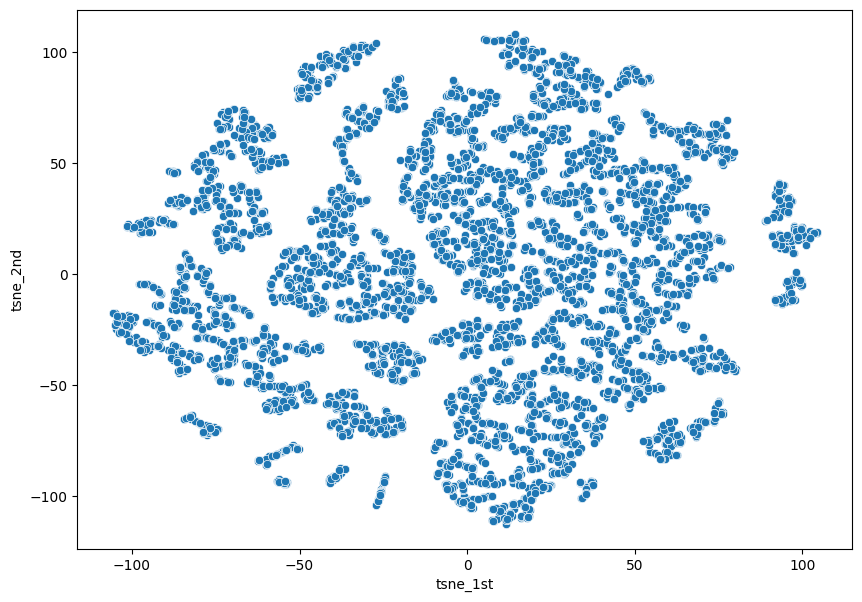

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(10, 7))
    
sns.scatterplot(
    data=X_tsne_df,
    x='tsne_1st', 
    y='tsne_2nd',
)

In [66]:
#mapping